# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
# env = UnityEnvironment(file_name="./VisualBanana_Linux/Banana.x86_64")
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import random
import torch
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Set options for matplotlib
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)
# Hide Matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore")

# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'

In [7]:
from agent import Agent

# Initiate the agent with the parameters for this project
# state_size: The state space has 37 dimensions and contains the agent's velocity, 
#             along with ray-based perception of objects around agent's forward direction.
# action_size: At each time step, the agent has four actions at its disposal, walk forward, walk backward,
#              turn left, turn right

agent = Agent(state_size=37, action_size=4, seed=42)

In [8]:
# Deep Q-Learning function

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, train_mode=True, 
        ckpt_path='pth_checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
        
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        state = env_info.vector_observations[0]                 # get current state        
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                      # select an action
            env_info = env.step(action.astype(int))[brain_name]             # send action to environment
            next_state = env_info.vector_observations[0]        # get next state
            reward = env_info.rewards[0]                        # get reward
            done = env_info.local_done[0]                       # see if episode has finished
            agent.step(state, action, reward, next_state, done) # learning step
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)          # save most recent score to window
        scores.append(score)                 # save most recent score to total
        moving_avg = np.mean(scores_window)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avg))
        if moving_avg >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, moving_avg))
            if train_mode:
                torch.save(agent.qnetwork_local.state_dict(), ckpt_path)
            break
    return scores, moving_avgs

In [9]:
# i = 0
# fc1_units = 64
# fc2_units = 64
# use_double = True
# use_dueling = True
# print(f"Running model {i}")
# agent = Agent(state_size=state_size, action_size=action_size, seed=0,
#                                   use_double=use_double, useb_dueling=use_dueling, fc1_units=fc1_units,
#                                   fc2_units=fc2_units)
# scores, avgs = dqn(n_episodes=600, eps_decay=0.98, eps_end=0.02,
#                                        ckpt_path=f'pth_checkpoints/v{i}_checkpoint.pth')

In [10]:
result_table = pd.DataFrame()

Running model 0
Episode 100	Average Score: 0.58
Episode 200	Average Score: 3.97
Episode 300	Average Score: 8.75
Episode 400	Average Score: 11.74
Episode 460	Average Score: 13.04
Environment solved in 360 episodes!	Average Score: 13.04


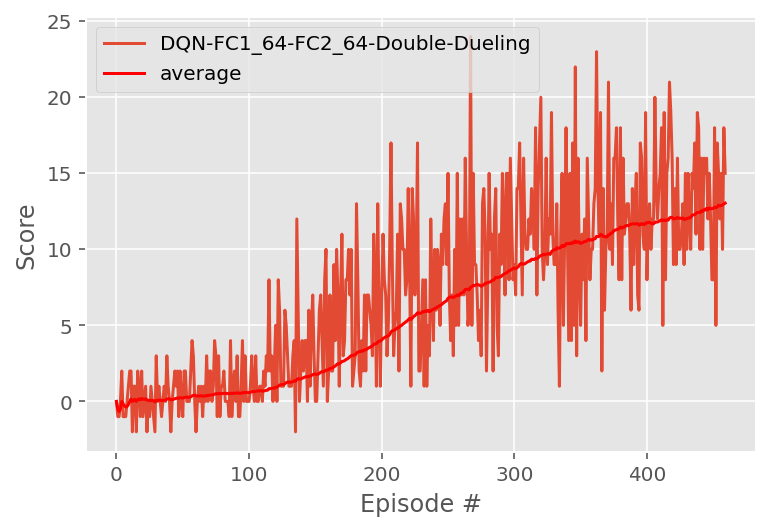

Running model 1
Episode 100	Average Score: 1.73
Episode 200	Average Score: 6.96
Episode 300	Average Score: 11.37
Episode 352	Average Score: 13.05
Environment solved in 252 episodes!	Average Score: 13.05


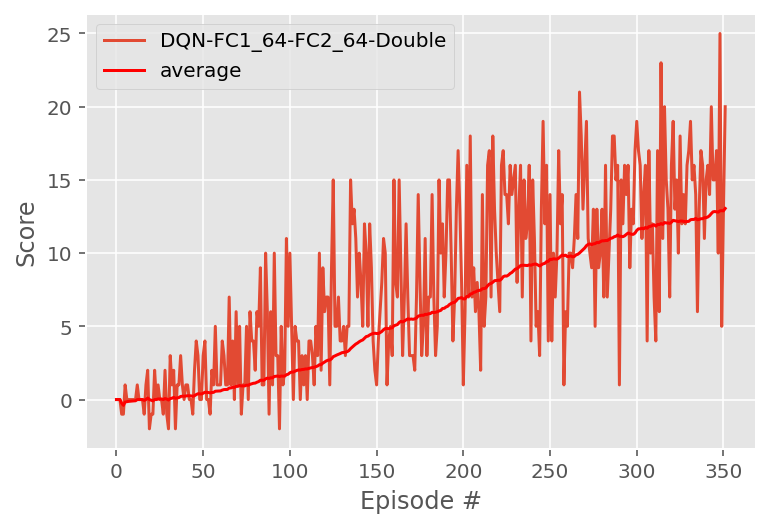

Running model 2
Episode 100	Average Score: 1.89
Episode 200	Average Score: 6.63
Episode 300	Average Score: 10.61
Episode 379	Average Score: 13.05
Environment solved in 279 episodes!	Average Score: 13.05


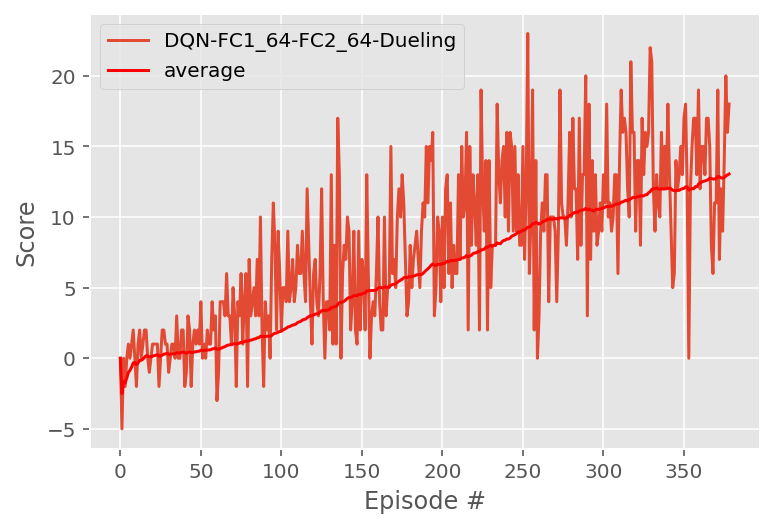

Running model 3
Episode 100	Average Score: 1.62
Episode 200	Average Score: 6.55
Episode 300	Average Score: 11.34
Episode 349	Average Score: 13.02
Environment solved in 249 episodes!	Average Score: 13.02


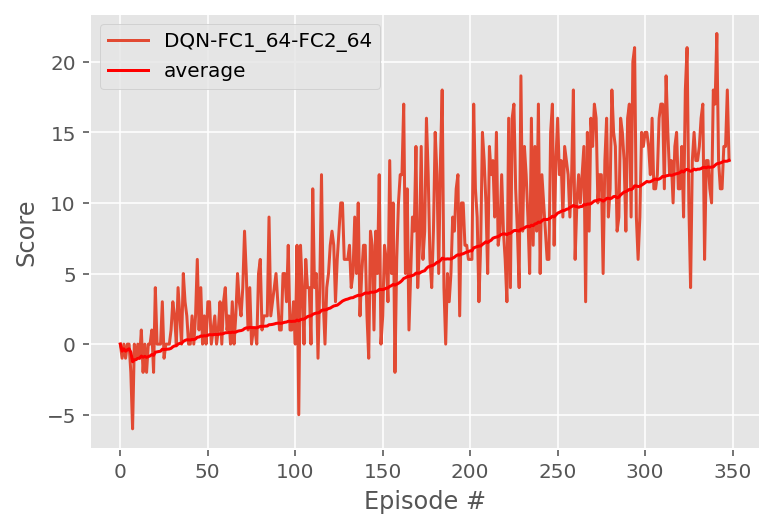

Running model 4
Episode 100	Average Score: 1.38
Episode 200	Average Score: 5.97
Episode 300	Average Score: 9.98
Episode 400	Average Score: 12.90
Episode 413	Average Score: 13.04
Environment solved in 313 episodes!	Average Score: 13.04


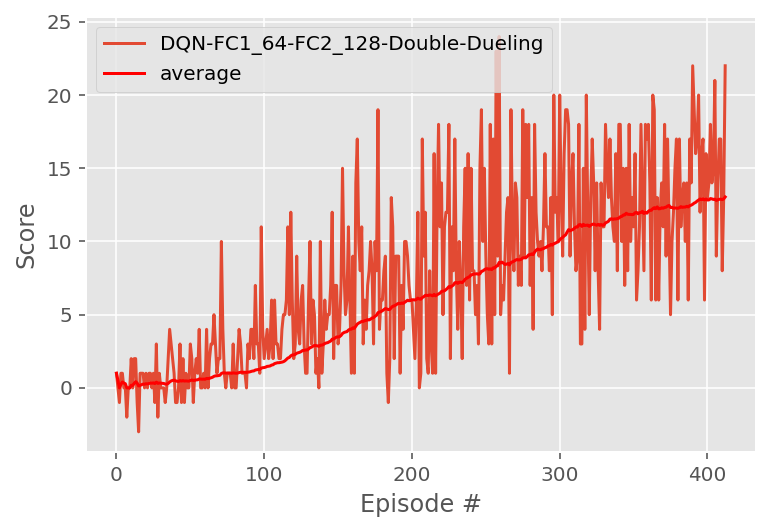

Running model 5
Episode 100	Average Score: 1.36
Episode 200	Average Score: 5.60
Episode 300	Average Score: 10.22
Episode 400	Average Score: 12.44
Episode 415	Average Score: 13.01
Environment solved in 315 episodes!	Average Score: 13.01


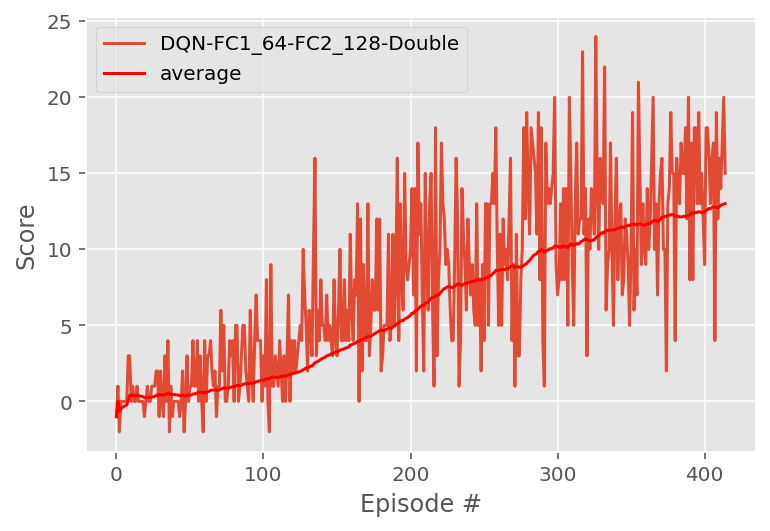

Running model 6
Episode 100	Average Score: 2.08
Episode 200	Average Score: 7.46
Episode 300	Average Score: 11.24
Episode 400	Average Score: 13.02

Environment solved in 300 episodes!	Average Score: 13.02


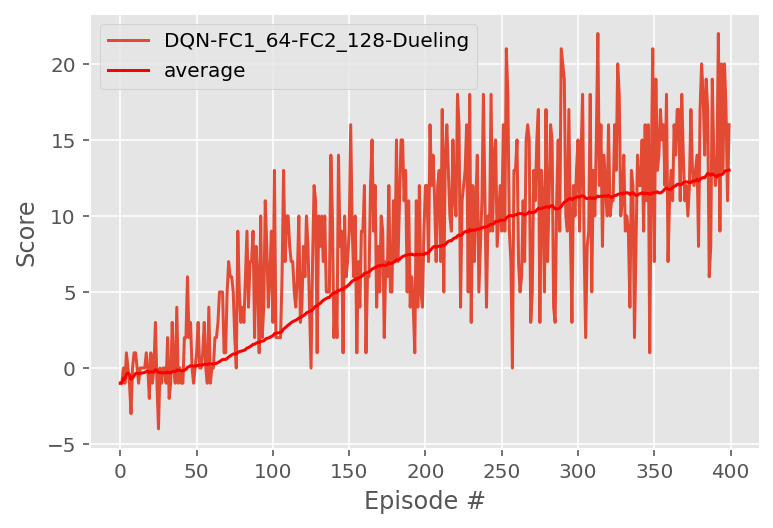

Running model 7
Episode 100	Average Score: 2.30
Episode 200	Average Score: 6.82
Episode 300	Average Score: 10.13
Episode 400	Average Score: 11.82
Episode 443	Average Score: 13.01
Environment solved in 343 episodes!	Average Score: 13.01


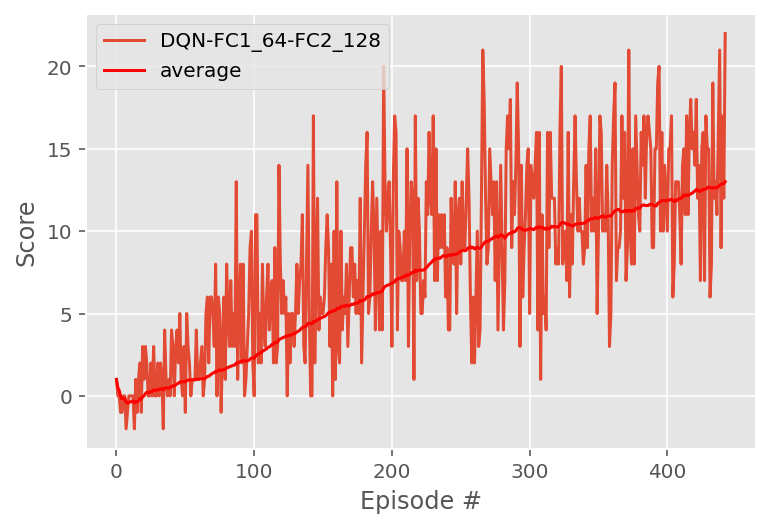

Running model 8
Episode 100	Average Score: 2.11
Episode 200	Average Score: 7.06
Episode 300	Average Score: 11.27
Episode 331	Average Score: 13.02
Environment solved in 231 episodes!	Average Score: 13.02


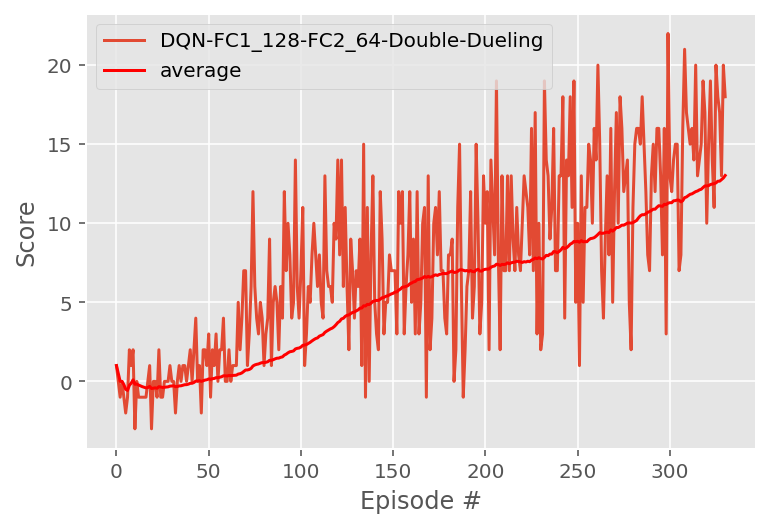

Running model 9
Episode 100	Average Score: 1.29
Episode 200	Average Score: 6.68
Episode 300	Average Score: 11.35
Episode 400	Average Score: 11.91
Episode 446	Average Score: 13.01
Environment solved in 346 episodes!	Average Score: 13.01


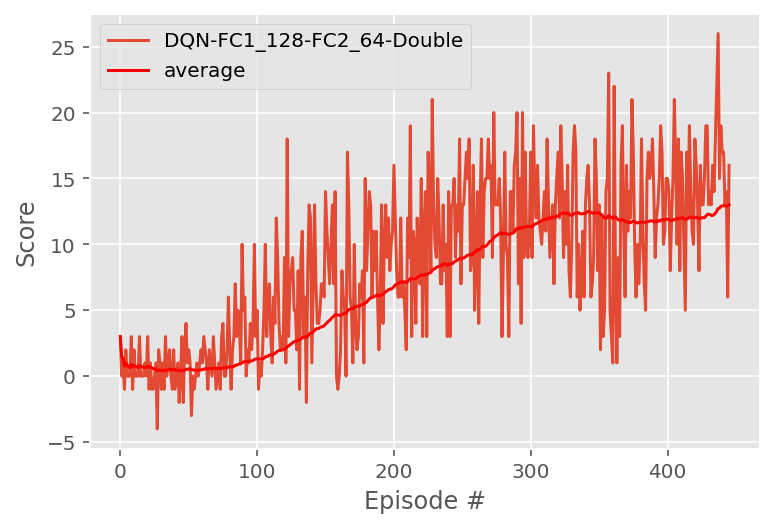

Running model 10
Episode 100	Average Score: 0.97
Episode 200	Average Score: 7.65
Episode 300	Average Score: 9.61
Episode 400	Average Score: 12.97
Episode 403	Average Score: 13.03
Environment solved in 303 episodes!	Average Score: 13.03


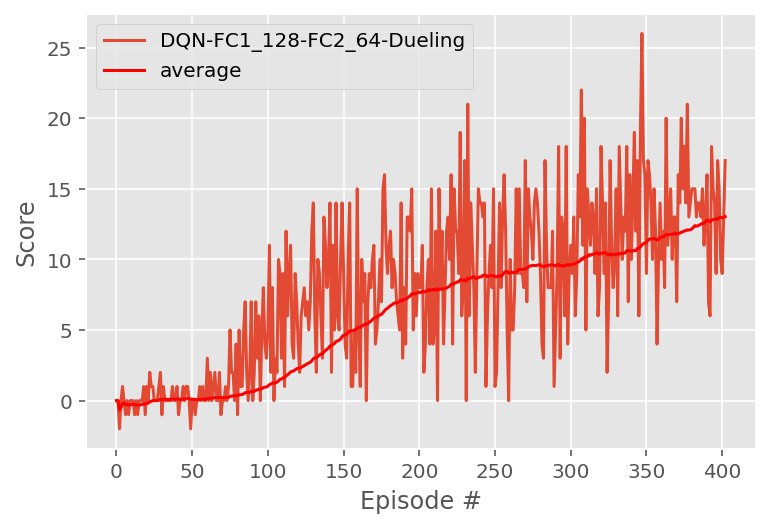

Running model 11
Episode 100	Average Score: 1.33
Episode 200	Average Score: 5.69
Episode 300	Average Score: 10.24
Episode 400	Average Score: 12.38
Episode 414	Average Score: 13.06
Environment solved in 314 episodes!	Average Score: 13.06


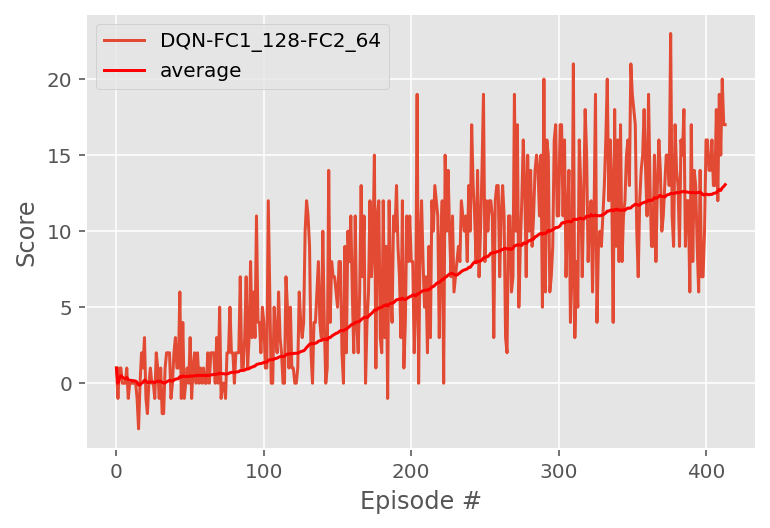

Running model 12
Episode 100	Average Score: 4.35
Episode 200	Average Score: 10.61
Episode 300	Average Score: 12.25
Episode 333	Average Score: 13.07
Environment solved in 233 episodes!	Average Score: 13.07


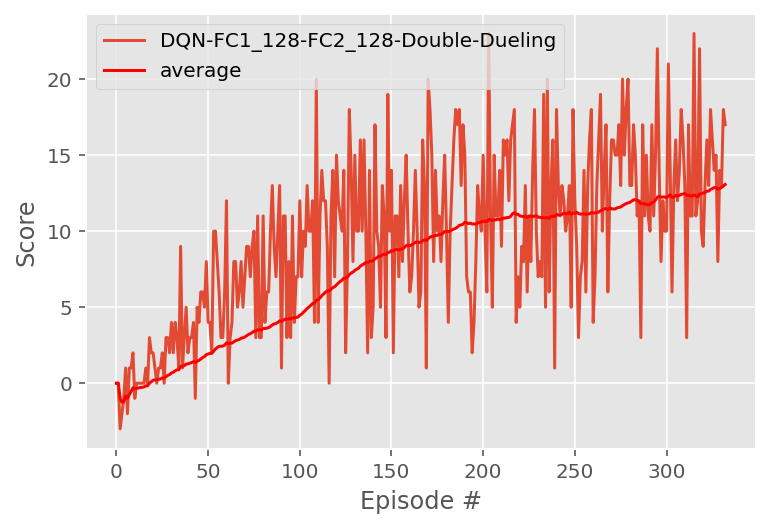

Running model 13
Episode 100	Average Score: 1.06
Episode 200	Average Score: 5.00
Episode 300	Average Score: 8.73
Episode 398	Average Score: 13.04
Environment solved in 298 episodes!	Average Score: 13.04


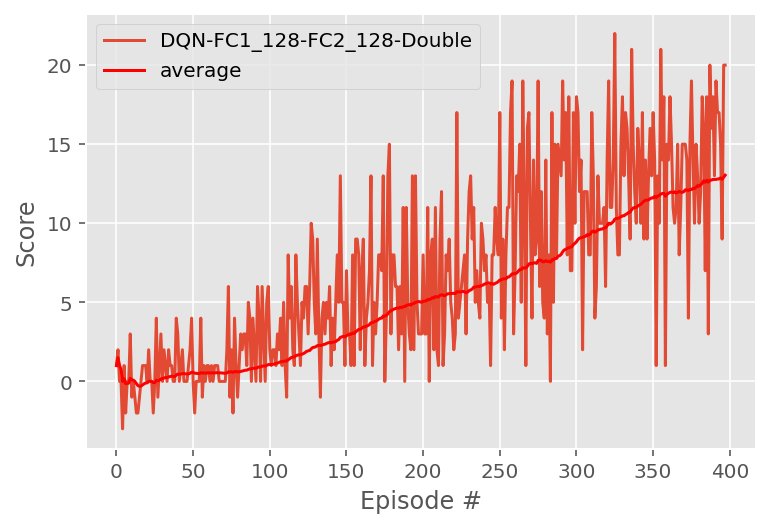

Running model 14
Episode 100	Average Score: 3.87
Episode 200	Average Score: 9.33
Episode 300	Average Score: 12.98
Episode 301	Average Score: 13.01
Environment solved in 201 episodes!	Average Score: 13.01


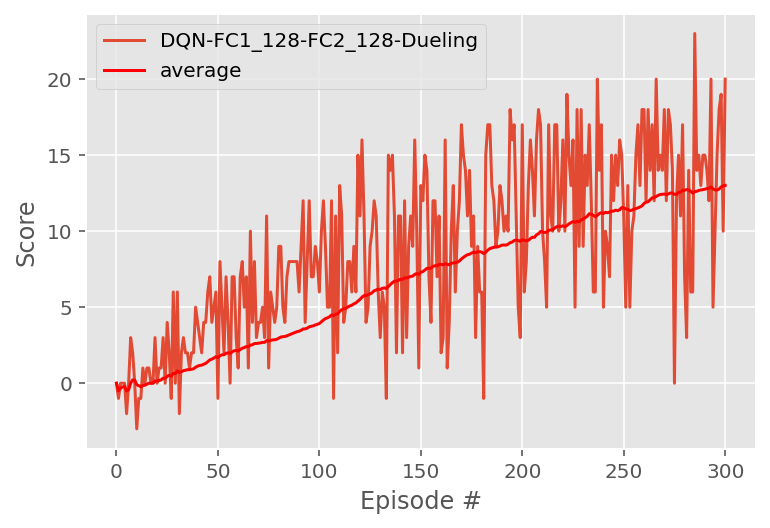

Running model 15
Episode 100	Average Score: 4.66
Episode 200	Average Score: 9.63
Episode 300	Average Score: 11.01
Episode 400	Average Score: 12.52
Episode 410	Average Score: 13.01
Environment solved in 310 episodes!	Average Score: 13.01


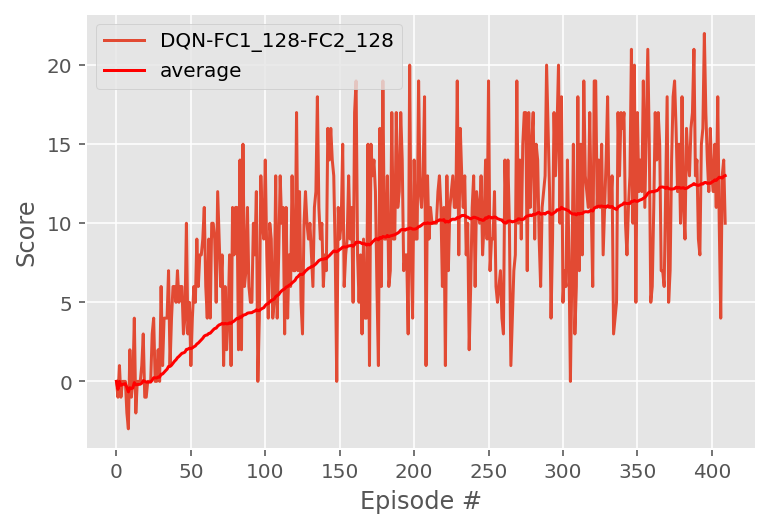

In [12]:
# run the training loop

i = 0
for fc1_units in [64, 128]:
    for fc2_units in [64, 128]:
        for use_double in [True, False]:
            for use_dueling in [True, False]:
                    print(f"Running model {i}")
                    agent = Agent(state_size=state_size, action_size=action_size, seed=0,
                                  use_double=use_double, use_dueling=use_dueling, fc1_units=fc1_units,
                                  fc2_units=fc2_units)
                    scores, avgs = dqn(n_episodes=600, eps_decay=0.98, eps_end=0.02,
                                       ckpt_path=f'pth_checkpoints/v{i}_checkpoint.pth')

                    # plot the scores
                    fig = plt.figure()
                    ax = fig.add_subplot(111)
                    base_label = "DQN-"
                    fc1_label = f"FC1_{fc1_units}-"
                    fc2_label = f"FC2_{fc2_units}-"
                    double_label = dueling_label = ""
                    if use_double:
                        double_label = "Double-"
                    if use_dueling:
                        dueling_label = "Dueling-"
                    label = (base_label+fc1_label+fc2_label+double_label+dueling_label)[:-1]
                    plt.plot(np.arange(len(scores)), scores, label=label)
                    plt.plot(np.arange(len(scores)), avgs, c='r', label='average')
                    plt.ylabel('Score')
                    plt.xlabel('Episode #')
                    plt.legend(loc='upper left');
                    plt.show()
                    fig.savefig(f"images/{label}.png")
                    
                    result_table = result_table.append({'FC1_Units': fc1_units,
                                         'FC2_Units': fc2_units,
                                         'Use_Double': use_double,
                                         'Use_Dueling': use_dueling,
                                         'Average_Score': avgs[-1],
                                         'Number_of_Episodes': len(scores)-100}, ignore_index=True)

                    i+=1

In [14]:
result_table.to_csv("result_table.csv")